# Import libraries

In [1]:
import datetime as dt
from pathlib import Path

import numpy as np
import pandas as pd
import re

import matplotlib.pyplot as plt

# Importing and sanitizing

Before we start doing the analysis, we'll have to import and sanitize the data into Python. This involves converting the date format that we received from the cameras into ISO format so we can easily manipulate the data with pivot tables later. 

We'll import the data into a dataframe (read: special table) with the columns separated based on the location of the entrance as well as whether it was an entry or exit count. We'll code the process of importing and sanitizing in separate functions to keep our notebook neat and tidy.

In [2]:
def import_data(report_files_path):
    data = {'MAIN':[], 'SOUTH':[], 'STARBUCKS':[]}

    for file in report_files_path:

        with file.open() as f:
            report_date = dt.datetime.strptime(re.search('\d{8}', f.name)[0], '%Y%m%d').date()

            # Parse the file and remake the first column to be in an ISO dateformat for easy access later
            file_data = [','.join(x.split()) for x in f.read().split('\n')][1:-1]
            file_data = [
                report_date.strftime('%Y-%m-%d') + ' ' 
                + str.replace(x, re.search('-\d{2}:\d{2}', x)[0], '') 
                for x in file_data
            ]

            camera = str.upper(file.parent.stem)

            data[camera] += file_data
    
    return data
            
def sanitize_data(data):
    for camera in data:
        # Expand the series, currently delimited by commas, into a dataframe
        # then sort it so it is chronologically ascending
        data[camera] = pd.Series(data[camera]).str.split(',', expand = True).sort_values(0)

        # Data is originally string type. Convert to int type to do math later
        data[camera][1] = data[camera][1].astype(int)
        data[camera][2] = data[camera][2].astype(int)

        # Rename columns
        data[camera].columns = ['DATE', f'{camera}_IN', f'{camera}_OUT']
        data[camera] = data[camera].set_index('DATE')

    # Combine all tables into a single one, filling NaN as 0
    data = pd.concat([data[camera] for camera in data], axis = 1).fillna(0)

    # Change index from string to datetime object so we can use pivot tables later
    data.index = pd.to_datetime(data.index)
    
    return data

And now we import the data, and have a look at the first ten rows to see what we're dealing with.

In [3]:
current_dir = Path('./')
report_files = sorted(list(current_dir.glob('**/Daily_Report_*.txt')))

raw_data = import_data(report_files)
data = sanitize_data(raw_data)

data.head(10)

,MAIN_IN,MAIN_OUT,SOUTH_IN,SOUTH_OUT,STARBUCKS_IN,STARBUCKS_OUT
2020-05-06 00:00:00,0.0,0.0,0,0,0.0,0.0
2020-05-06 01:00:00,0.0,0.0,0,0,0.0,0.0
2020-05-06 02:00:00,0.0,0.0,0,0,0.0,0.0
2020-05-06 03:00:00,0.0,0.0,0,0,0.0,0.0
2020-05-06 04:00:00,0.0,0.0,2,1,0.0,0.0
2020-05-06 05:00:00,0.0,0.0,0,1,0.0,0.0
2020-05-06 06:00:00,0.0,0.0,2,0,0.0,0.0
2020-05-06 07:00:00,0.0,0.0,2,2,0.0,0.0
2020-05-06 08:00:00,0.0,0.0,5,1,0.0,0.0
2020-05-06 09:00:00,0.0,0.0,4,1,0.0,0.0


# Analysis

We have our data - great! Let's have a look at the daily entry/exit count for each of the entrances. Our data's frequency is hourly so we'll have to resample it, aggregating by day.

<Figure size 432x288 with 0 Axes>

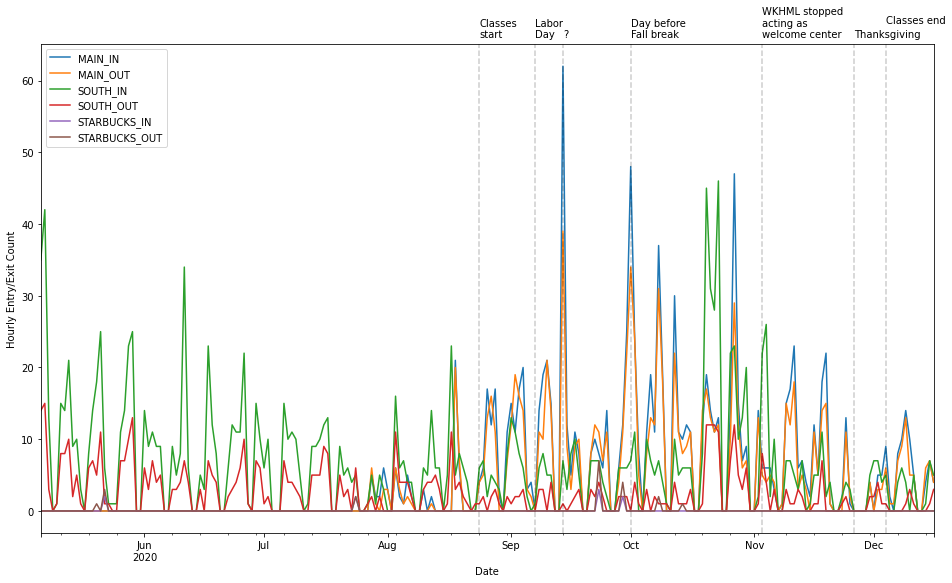

In [4]:
plt.figure()
data.resample('D').sum().plot(figsize = (16, 9))
plt.xlabel('Date')
plt.ylabel('Hourly Entry/Exit Count')

notable_dates = [dt.date(2020, 8, 24), dt.date(2020, 9, 7), 
                 dt.date(2020, 9, 14), dt.date(2020, 10, 1), 
                 dt.date(2020, 11, 3), dt.date(2020, 11, 26), 
                 dt.date(2020, 12, 4)
                ]

reason = ['Classes\nstart', 'Labor\nDay', 
          '?', 'Day before\nFall break', 
          'WKHML stopped\nacting as\nwelcome center', 'Thanksgiving', 
          'Classes end'
         ]

t = []
for d, r in zip(notable_dates, reason):
    plt.axvline(x = d, color = 'k', linestyle = 'dashed', alpha = 0.2)
    t.append(plt.text(d, 66, r))
    
t[-1].set_position((d, 68))

The daily entry/exit counts are low from the library closure due to COVID-19. Notable dates from the semester are included on the plot. I am not aware of any events that would represent the spike at 09/14.

We now turn to unsupervised learning methods in machine-learning to see if we can find some strucure within our data. Instead of having the date and hours in the index of our dataframe, let's pivot the table so that the hours form the columns.

In [5]:
pivoted = data.pivot_table(['MAIN_IN', 'SOUTH_IN', 'STARBUCKS_IN', 'MAIN_OUT', 'SOUTH_OUT', 'STARBUCKS_OUT'],
                          index = data.index.date,
                          columns = data.index.hour,
                          fill_value = 0)

pivoted.head(10)

MAIN_IN                             ... STARBUCKS_OUT              \
                0  1  2  3  4  5  6  7  8  9   ...            14 15 16 17 18   
2020-05-06       0  0  0  0  0  0  0  0  0  0  ...             0  0  0  0  0   
2020-05-07       0  0  0  0  0  0  0  0  0  0  ...             0  0  0  0  0   
2020-05-08       0  0  0  0  0  0  0  0  0  0  ...             0  0  0  0  0   
2020-05-09       0  0  0  0  0  0  0  0  0  0  ...             0  0  0  0  0   
2020-05-10       0  0  0  0  0  0  0  0  0  0  ...             0  0  0  0  0   
2020-05-11       0  0  0  0  0  0  0  0  0  0  ...             0  0  0  0  0   
2020-05-12       0  0  0  0  0  0  0  0  0  0  ...             0  0  0  0  0   
2020-05-13       0  0  0  0  0  0  0  0  0  0  ...             0  0  0  0  0   
2020-05-14       0  0  0  0  0  0  0  0  0  0  ...             0  0  0  0  0   
2020-05-15       0  0  0  0  0  0  0  0  0  0  ...             0  0  0  0  0   

                           
           19 20 21 22 23  
2020-05-06  0  0  0  0  0  
2020-05-07  0  0  0  0  0  
2020-05-08  0  0  0  0  0  
2020-05-09  0  0  0  0  0  
2020-05-10  0  0  0  0  0  
2020-05-11  0  0  0  0  0  
2020-05-12  0  0  0  0  0  
2020-05-13  0  0  0  0  0  
2020-05-14  0  0  0  0  0  
2020-05-15  0  0  0  0  0  

[10 rows x 144 columns]

In [6]:
X = pivoted.values
X.shape

(225, 144)

We extract only the values from the dataframe, giving us a matrix with 144 dimensions. Our goal is to perform dimensionality reduction so that we can visualize this data and hopefully find some structure. My first choice is to use _Principal Component Analysis_ (PCA). 

PCA is a linear dimensionality reduction technique that uses Singular Value Decomposition. It is important for us to scale the data so that each column is centered to the mean and normalized. Fortunately, sklearn.preprocessing has the method _scale_ that will do that for us. Let's first have a look at the percentage variance accounted by our principal components.

In [7]:
from sklearn.preprocessing import scale
from sklearn.decomposition import PCA

X_s = scale(X)

pca = PCA(n_components=X.shape[1])
pca.fit(X_s)

PCA(n_components=144)

Text(0, 0.5, 'Percent Variance Accounted')

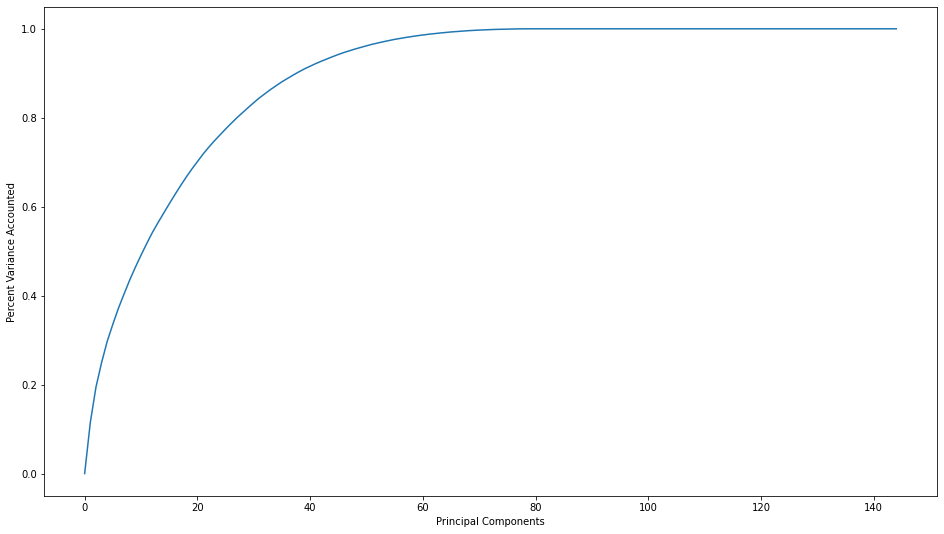

In [8]:
var_accounted = pca.explained_variance_

plt.figure(figsize=(16, 9))
plt.plot(
    range(0, len(var_accounted) + 1), 
    np.cumsum(np.append(0, var_accounted))/np.sum(var_accounted))

plt.xlabel('Principal Components')
plt.ylabel('Percent Variance Accounted')

We see from the plot above that about 99% of the variance in our dataset can be accounted by, what looks to be, the first 65 principal components. This mean we can effectively remove the remaining 79 components, reducing the dimensions of the dataset from 144 dimensions to 65 dimensions, at the cost of only losing 1% of variance in our dataset. 

We now extract the eigenvectors that account the 99% of variance...

In [9]:
pca = PCA(0.99)
pca.fit(X_s)
Xpca = pca.fit_transform(X_s)

print(f'Number of principal components needed to account 99% of variance: {len(pca.explained_variance_)}')

Number of principal components needed to account 99% of variance: 63


and we end up extracting only the first 63 principal components. This is great but still cannot be visualized  easily. We now look to a different technique known as _t-Stochastic Neighbour Embedding_ (tSNE). The algorithm runs at $\mathcal{O}(n^2)$, so the reduced dimensions will help speed up the computation.

We'll set so that tSNE attempts to reduce the 63 dimensions down to 2. The random state has been set to 0 so that the results here are reproducable.

In [10]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, random_state=0)
tsne_obj = tsne.fit_transform(X_s)

Let's see how our data looks like. We'll sum up the total visits per day and use it to colour our visualization.

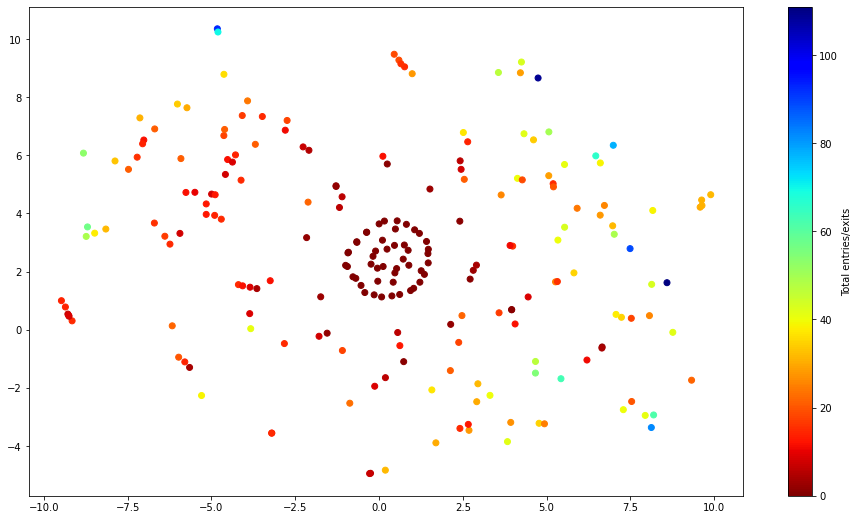

In [11]:
total_trips = X.sum(1)

plt.figure(figsize=(16, 9))
plt.scatter(tsne_obj[:, 0], tsne_obj[:, 1], c=total_trips, cmap='jet_r')

plt.colorbar(label='Total entries/exits');

_Et voila!_ We find a cluster in the center, and the remaining points seem to be scattered around it. A quick observation tells us that as we move radially outwards from the center cluster, the total entries/exits increases. The points in the center cluster epresent days where 0 or close to 0 entries/exits happen per day. Since the library's counter report continues to send data on weekends, we can hypothesisze that these represent the weekend where no staff enters the library. 

We investigate this further and plot the same figure again except mapping the colours so that they correspond to the days of the week.

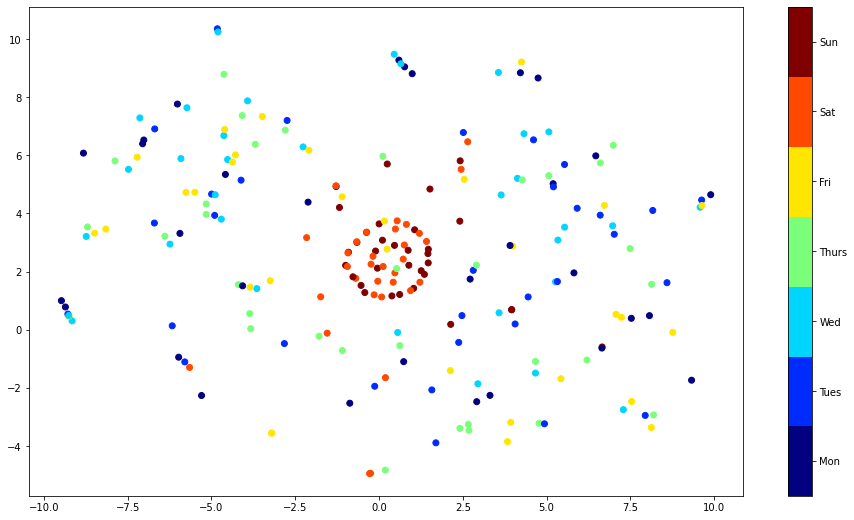

In [12]:
plt.figure(figsize=(16, 9))

dayofweek = pd.to_datetime(pivoted.index).dayofweek
plt.scatter(tsne_obj[:, 0], tsne_obj[:, 1], c=dayofweek,
            cmap=plt.cm.get_cmap('jet', 7))
cb = plt.colorbar(ticks=range(7))
cb.set_ticklabels(['Mon', 'Tues', 'Wed', 'Thurs', 'Fri', 'Sat', 'Sun'])
plt.clim(-0.5, 6.5);

Our intuition is correct! The center cluster is made up of mostly Saturdays and Sundays. There is a Thursdy and two Fridays that are within that cluster, potentially due to public holidays, so we'll have a closer look at them later.

We now turn to separating the center cluster from the all other points. We can turn to clustering algorithms, but the cluster in the center is close to being a circle that we can probably use a simpler approach. Let's first translate the points so that the cluster is centered at the origin to make the computation easier. A rough estimation will suffice given that accuracy is not imperative here -- we're aiming to only classify the datapoints.

Once centered at the origin, we'll scale a unit circle to engulf the center cluster. All the points within the boundary of the scaled unit circle will be the first cluster whilst the remaining points be the second.

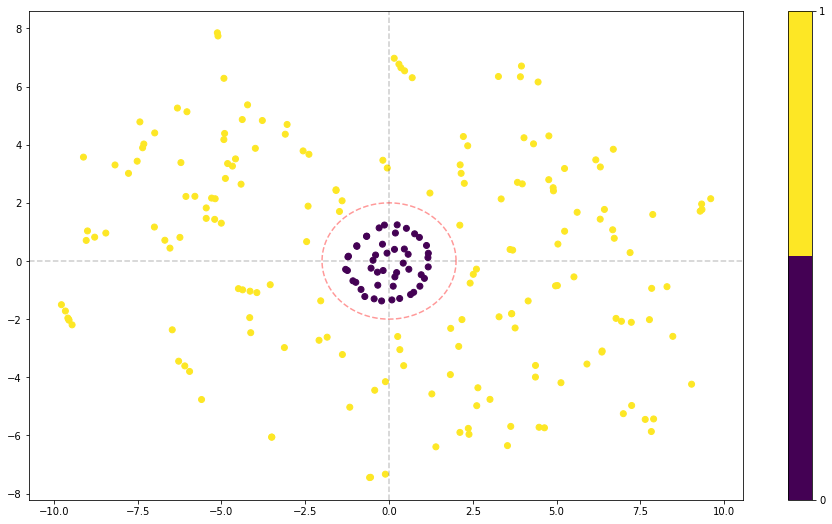

In [13]:
x = tsne_obj[:, 0] - 0.3
y = tsne_obj[:, 1] - 2.5

circle_radius = 2

cluster = (np.sqrt(x**2 + y**2) >= circle_radius).astype(int)

theta = np.linspace(0, 2*np.pi, 1000)
x = circle_radius * np.cos(theta)
y = circle_radius * np.sin(theta)

plt.figure(figsize=(16, 9))
plt.scatter(tsne_obj[:, 0] - 0.3, tsne_obj[:, 1] - 2.5, c=cluster, cmap=plt.cm.get_cmap('viridis', 2))
plt.colorbar(ticks=range(2))

plt.axhline(0, color = 'k', alpha = 0.2, linestyle = 'dashed')
plt.axvline(0, color = 'k', alpha = 0.2, linestyle = 'dashed')

plt.plot(x, y, color = 'red', linestyle ='dashed', alpha = 0.4)

Success! Let's add this information to our original dataframe and utilize it to explore our data further.

In [14]:
pivoted['CLUSTER'] = cluster
data = data.join(pivoted['CLUSTER'], on=data.index.date)
data.head(10)

,MAIN_IN,MAIN_OUT,SOUTH_IN,SOUTH_OUT,STARBUCKS_IN,STARBUCKS_OUT,CLUSTER
2020-05-06 00:00:00,0.0,0.0,0,0,0.0,0.0,1
2020-05-06 01:00:00,0.0,0.0,0,0,0.0,0.0,1
2020-05-06 02:00:00,0.0,0.0,0,0,0.0,0.0,1
2020-05-06 03:00:00,0.0,0.0,0,0,0.0,0.0,1
2020-05-06 04:00:00,0.0,0.0,2,1,0.0,0.0,1
2020-05-06 05:00:00,0.0,0.0,0,1,0.0,0.0,1
2020-05-06 06:00:00,0.0,0.0,2,0,0.0,0.0,1
2020-05-06 07:00:00,0.0,0.0,2,2,0.0,0.0,1
2020-05-06 08:00:00,0.0,0.0,5,1,0.0,0.0,1
2020-05-06 09:00:00,0.0,0.0,4,1,0.0,0.0,1


We first group our data by cluster, then aggregate by the mean count for each hour. We can then plot the clusters into their respective subplots to see what the differences are.

In [15]:
by_hour = data.groupby(['CLUSTER', data.index.time]).mean()
by_hour.head(10)

MAIN_IN  MAIN_OUT  SOUTH_IN  SOUTH_OUT  STARBUCKS_IN  \
CLUSTER                                                                  
0       00:00:00      0.0       0.0       0.0        0.0           0.0   
        01:00:00      0.0       0.0       0.0        0.0           0.0   
        02:00:00      0.0       0.0       0.0        0.0           0.0   
        03:00:00      0.0       0.0       0.0        0.0           0.0   
        04:00:00      0.0       0.0       0.0        0.0           0.0   
        05:00:00      0.0       0.0       0.0        0.0           0.0   
        06:00:00      0.0       0.0       0.0        0.0           0.0   
        07:00:00      0.0       0.0       0.0        0.0           0.0   
        08:00:00      0.0       0.0       0.0        0.0           0.0   
        09:00:00      0.0       0.0       0.0        0.0           0.0   

                  STARBUCKS_OUT  
CLUSTER                          
0       00:00:00            0.0  
        01:00:00            0.0  
        02:00:00            0.0  
        03:00:00            0.0  
        04:00:00            0.0  
        05:00:00            0.0  
        06:00:00            0.0  
        07:00:00            0.0  
        08:00:00            0.0  
        09:00:00            0.0

Plotting the two clusters yields us:

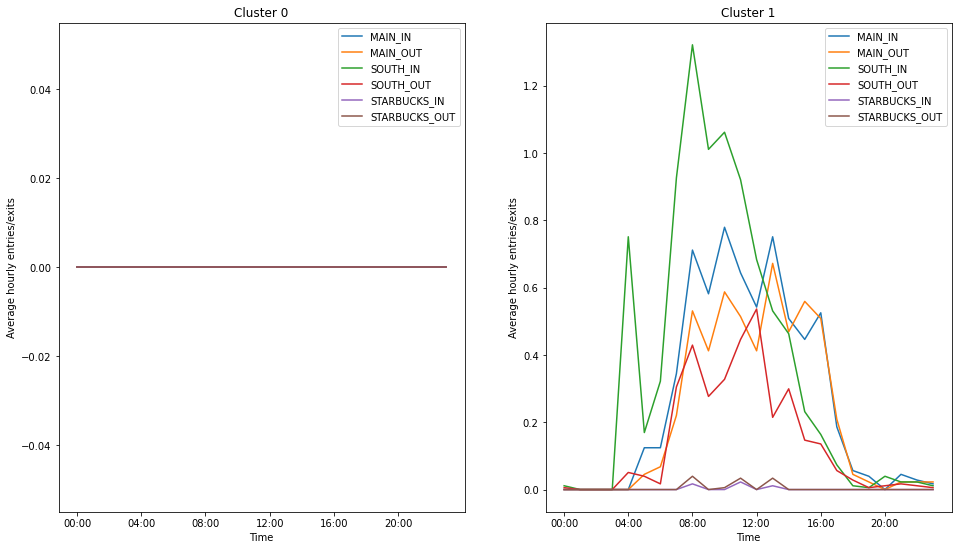

In [16]:
fig, ax = plt.subplots(1, 2, figsize=(16, 9))
hourly_ticks = 4 * 60 * 60 * np.arange(6)

for i in range(2):
    by_hour.loc[i].plot(ax=ax[i], xticks=hourly_ticks)
    ax[i].set_title('Cluster {0}'.format(i))
    ax[i].set_xlabel('Time')
    ax[i].set_ylabel('Average hourly entries/exits')

Cluster 0 has no data whatsoever confirming our hypothesis that it represents days that nobody enters the library. Let's enlarge the plot for Cluster 1. We'll mark the hours where we see spikes happening.

<Figure size 432x288 with 0 Axes>

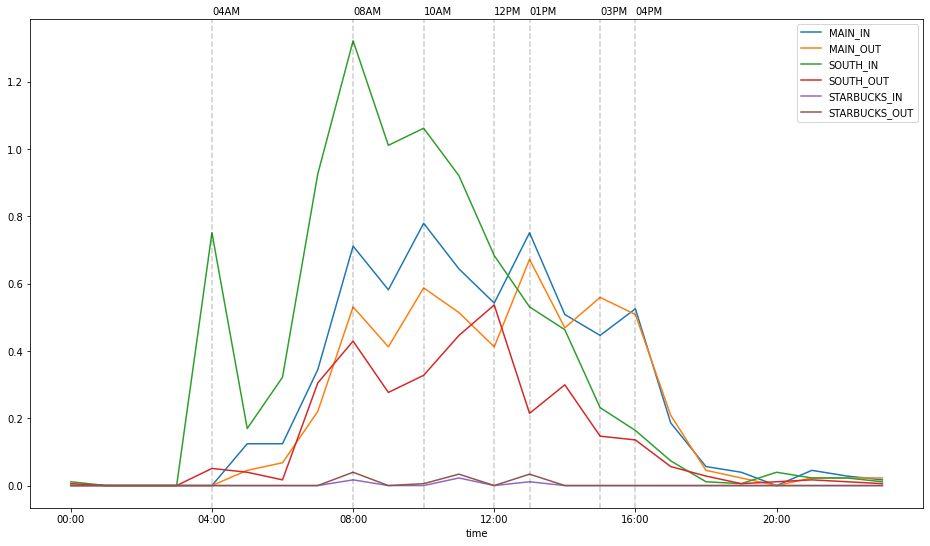

In [17]:
plt.figure()
by_hour.loc[1].plot(xticks=hourly_ticks, figsize=(16,9))

notable_time = [
    dt.time(4, 0), dt.time(8, 0),
    dt.time(10, 0), dt.time(12, 0),
    dt.time(13, 0), dt.time(15, 0),
    dt.time(16, 0)
]



for t in notable_time:
    plt.axvline(t, color='k', alpha=0.2, linestyle = 'dashed')
    plt.text(t, 1.4, t.strftime('%I%p'))

Cluster 1 has some interesting observations. We see spikes at 4AM and 8AM indicating that these are hours where staff consistently enter the library through the southern entrance (green). 10AM is another popular entry time.
We can also see when staff leave for lunch by noticing the red spike at 12PM (leaving, southern entrance) then a blue spike at 1PM (entering, main entrance).

What's going on with the Starbucks entrance?

<AxesSubplot:xlabel='time'>

<Figure size 432x288 with 0 Axes>

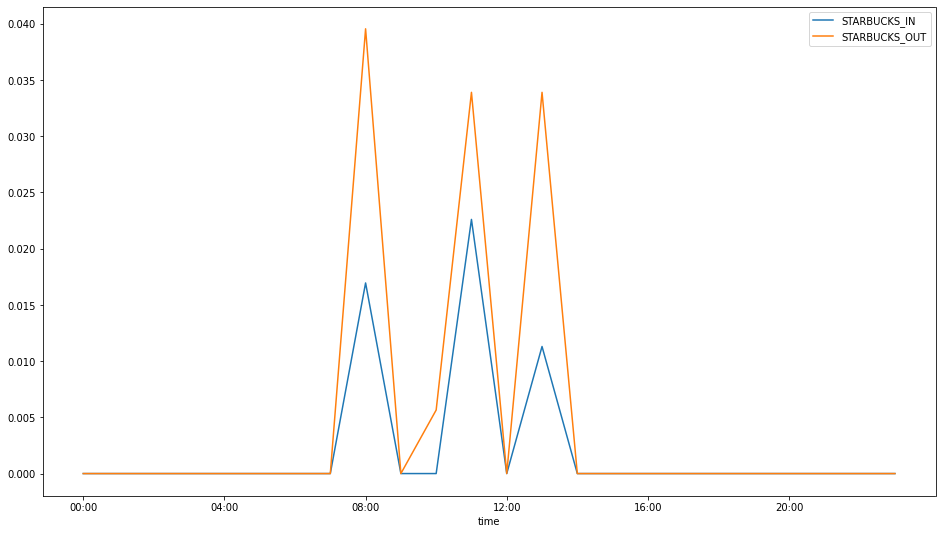

In [18]:
plt.figure()
by_hour.loc[1, ['STARBUCKS_IN', 'STARBUCKS_OUT']].plot(xticks=hourly_ticks, figsize=(16,9))

It seems that the camera picks up on average entries/exits at 8AM, 11AM, and 1PM. Perhaps these are the times when Bon Appetit enters the cafe to ensure all the equipment are running normally?

# Extras

Let's look at the tSNE plot once again with the days of the week as the colormap.

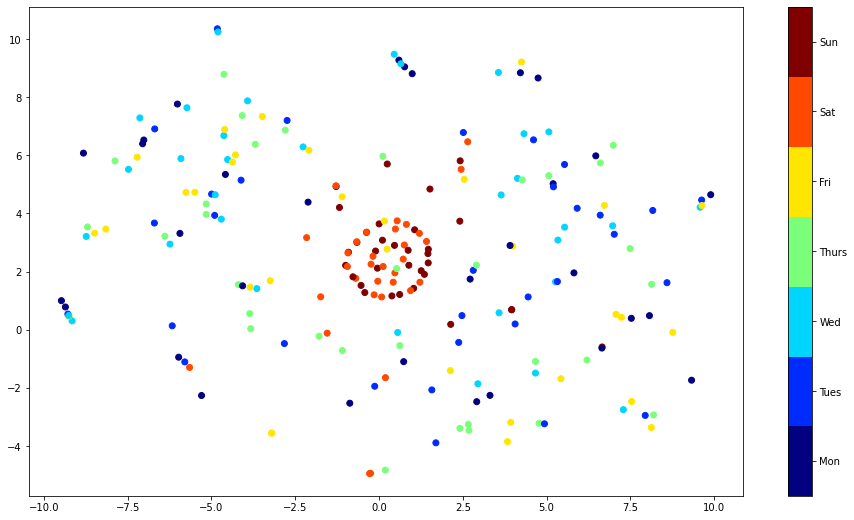

In [19]:
plt.figure(figsize=(16, 9))

dayofweek = pd.to_datetime(pivoted.index).dayofweek
plt.scatter(tsne_obj[:, 0], tsne_obj[:, 1], c=dayofweek,
            cmap=plt.cm.get_cmap('jet', 7))
cb = plt.colorbar(ticks=range(7))
cb.set_ticklabels(['Mon', 'Tues', 'Wed', 'Thurs', 'Fri', 'Sat', 'Sun'])
plt.clim(-0.5, 6.5);

Let's investigate the anomalies - weekdays in the weekend cluster and weekends in the weekday cluster. We make a new dataframe with columns cluster, the day of the week, and whether it is a weekend or not.

In [20]:
results = pd.DataFrame({'CLUSTER': cluster,
                        'DAY': pivoted.index.map(lambda x: x.strftime('%a')),
                        'IS_WEEKEND': (dayofweek > 4)},
                       index=pivoted.index)
results.head(10)

,CLUSTER,DAY,IS_WEEKEND
2020-05-06,1,Wed,False
2020-05-07,1,Thu,False
2020-05-08,1,Fri,False
2020-05-09,0,Sat,True
2020-05-10,1,Sun,True
2020-05-11,1,Mon,False
2020-05-12,1,Tue,False
2020-05-13,1,Wed,False
2020-05-14,1,Thu,False
2020-05-15,1,Fri,False


In [21]:
weekend_workdays = results.query('CLUSTER == 1 and IS_WEEKEND')
len(weekend_workdays)

19

It looks like there were 19 weekends since May (when the data starts) that staff has entered the library (to work?). The dates are:

In [22]:
weekend_workdays

,CLUSTER,DAY,IS_WEEKEND
2020-05-10,1,Sun,True
2020-05-16,1,Sat,True
2020-05-23,1,Sat,True
2020-05-24,1,Sun,True
2020-06-27,1,Sat,True
2020-07-12,1,Sun,True
2020-08-01,1,Sat,True
2020-08-16,1,Sun,True
2020-08-23,1,Sun,True
2020-08-29,1,Sat,True


How about the converse? Let's examine weekdays that are treated like weekends

In [23]:
off_weekday = results.query('CLUSTER == 0 and not IS_WEEKEND')
len(off_weekday)

3

In [24]:
off_weekday

,CLUSTER,DAY,IS_WEEKEND
2020-07-03,0,Fri,False
2020-11-26,0,Thu,False
2020-11-27,0,Fri,False


It seems that there are only three days that are treated like weekends. Let's see if we can figure out what these days are. We'll use pandas US Federal Holiday Calendar to our advantage.

In [25]:
from pandas.tseries.holiday import USFederalHolidayCalendar
cal = USFederalHolidayCalendar()
holidays = cal.holidays('2020', '2021', return_name=True)
holidays.head()

2020-01-01                 New Years Day
2020-01-20    Martin Luther King Jr. Day
2020-02-17                Presidents Day
2020-05-25                  Memorial Day
2020-07-03                      July 4th
dtype: object

We'll also add the days before and after the holidays to account for offset holidays.

In [26]:
holidays_all = pd.concat([holidays,
                         "Day Before " + holidays.shift(-1, 'D'),
                         "Day After " + holidays.shift(1, 'D')])
holidays_all = holidays_all.sort_index()
holidays_all.head()

2019-12-31                 Day Before New Years Day
2020-01-01                            New Years Day
2020-01-02                  Day After New Years Day
2020-01-19    Day Before Martin Luther King Jr. Day
2020-01-20               Martin Luther King Jr. Day
dtype: object

In [27]:
holidays_all.name = 'name'  # required for join
joined = off_weekday.join(holidays_all)
set(joined['name'])

{'Day After Thanksgiving', 'July 4th', 'Thanksgiving'}

Looks like the days off are for July 4th, Thanksgiving, and the day after Thanksgiving!